In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from rnn_tutorial import vrnn, generate_input_target, plot_integration, plot_weights

In [2]:
class vrnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(vrnn, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # define model layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """perform a forward pass of the model with input x"""

        n_seq = x.size(1) # aka number of batches
        h = self.init_hidden_state(n_seq) # current state

        self.h_all, h = self.rnn(x, h) # h_all stores h for t=0:seq_length

        y = self.out(self.h_all)

        return y, h

    def init_hidden_state(self, n_seq):
        """initialize hidden state of network to zeros"""
        h = torch.zeros(self.num_layers, n_seq, self.hidden_size)
        return h

def generate_input_target(input_size, seq_len, n_seq):
    """generates random noise sequence x and integration target t"""
    
    # sampling from the "standard normal" ~N(0, 1)
    x = np.random.randn(seq_len, n_seq, input_size)
    t = np.cumsum(x, axis=0)

    return x, t

def plot_integration(x, t, y=None, h=None, n_to_plot=5):
    """plots inputs x and integration targets t"""
    plt.figure(figsize=(10, 7))
    
    plt.subplot(311)
    plt.plot(x[:,:min(5, x.shape[1]),0])
    plt.axhline(color='k')
    plt.xlim([0, x.shape[0]-1])
    plt.title("x: (input) random samples from N(0, 1)")
    
    plt.subplot(312)
    plt.plot(t[:,:min(5, x.shape[1]),0])
    plt.axhline(color='k')
    plt.xlim([0, x.shape[0]-1])
    plt.title("t: (target) integral of x")
    
    if y is not None:
        y = y.detach().numpy() # needed bc of grad tracking
        plt.subplot(313)
        plt.plot(y[:,:min(5, x.shape[1]),0])
        plt.axhline(color='k')
        plt.xlim([0, x.shape[0]-1])
        plt.title("y: (output) rnn output")
    
    plt.tight_layout()
    plt.show()

def plot_weights(model):
    """plots recurrent, input, & output weights + biases of pytorch model"""
    plt.figure(figsize=(10, 7))

    plt.subplot(231)
    W_i = model.rnn.weight_ih_l0.detach().numpy()
    plt.stem(W_i, use_line_collection=True)
    plt.title('W_i: input weights')

    plt.subplot(232)
    W_r = model.rnn.weight_hh_l0.detach().numpy()
    plt.imshow(W_r, interpolation=None)
    plt.colorbar()
    plt.title('W_r: reccurrent weights')

    plt.subplot(233)
    W_o = np.squeeze(model.out.weight.detach().numpy())
    plt.stem(W_o, use_line_collection=True)
    plt.title('W_o: output weights')

    plt.subplot(234)
    b_i = model.rnn.bias_ih_l0.detach().numpy()
    plt.stem(b_i, use_line_collection=True)
    plt.title('b_i: input bias')

    plt.subplot(235)
    b_r = model.rnn.bias_hh_l0.detach().numpy()
    plt.stem(b_r, use_line_collection=True)
    plt.title('b_r: recurrent bias')

    plt.subplot(236)
    b_o = model.out.bias.detach().numpy()
    plt.stem(b_o, use_line_collection=True)
    plt.title('b_o: output bias')

    plt.show()

In [3]:
# check for GPU, use CPU if GPU not available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
# rnn parameters
input_size = 1 # must be 1 for integration example
hidden_size = 10 # feel free to change
output_size = 1 # must be 1 for integration example

# instantiate model and send it to device
model = vrnn(input_size, hidden_size, output_size)
model.to(device)

vrnn(
  (rnn): RNN(1, 10)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [5]:
# generate inputs x and integrated targets t
seq_len = 20 # length of input sequence (aka # of timesteps)
n_seq = 10 # number of i/o sequences to generate

x, t = generate_input_target(input_size, seq_len, n_seq)

# we need to convert numpy arrays to torch tensors
x = torch.Tensor(x)
t = torch.Tensor(t)

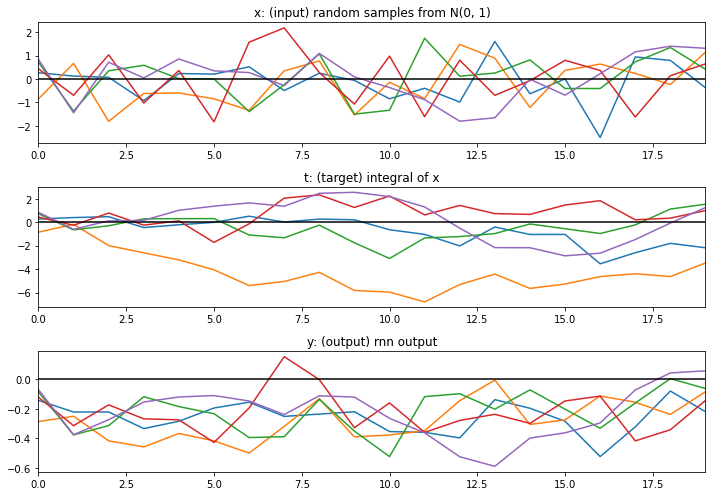

In [6]:
# take a look at rnn output pre-training
y, h = model.forward(x)
plot_integration(x, t, y)

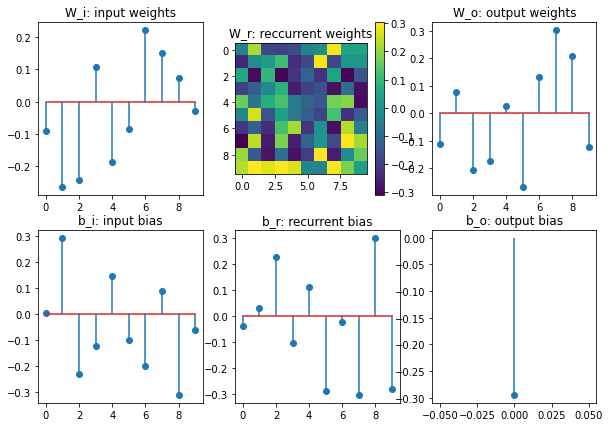

In [7]:
# take a look at the weights pre-training
plot_weights(model)

In [8]:
# training parameters
n_epochs = 500
lr = 0.01 # learning rate

# define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 20/500............. Loss: 6.2933
Epoch: 40/500............. Loss: 3.8200
Epoch: 60/500............. Loss: 2.5908
Epoch: 80/500............. Loss: 1.4020
Epoch: 100/500............. Loss: 0.7841
Epoch: 120/500............. Loss: 0.6134
Epoch: 140/500............. Loss: 0.3987
Epoch: 160/500............. Loss: 0.2794
Epoch: 180/500............. Loss: 0.2695
Epoch: 200/500............. Loss: 0.3788
Epoch: 220/500............. Loss: 0.1573
Epoch: 240/500............. Loss: 0.1484
Epoch: 260/500............. Loss: 0.2682
Epoch: 280/500............. Loss: 0.0978
Epoch: 300/500............. Loss: 0.0806
Epoch: 320/500............. Loss: 0.0670
Epoch: 340/500............. Loss: 0.1084
Epoch: 360/500............. Loss: 0.0637
Epoch: 380/500............. Loss: 0.0452
Epoch: 400/500............. Loss: 0.2602
Epoch: 420/500............. Loss: 0.0413
Epoch: 440/500............. Loss: 0.0334
Epoch: 460/500............. Loss: 0.0268
Epoch: 480/500............. Loss: 0.1689
Epoch: 500/500......

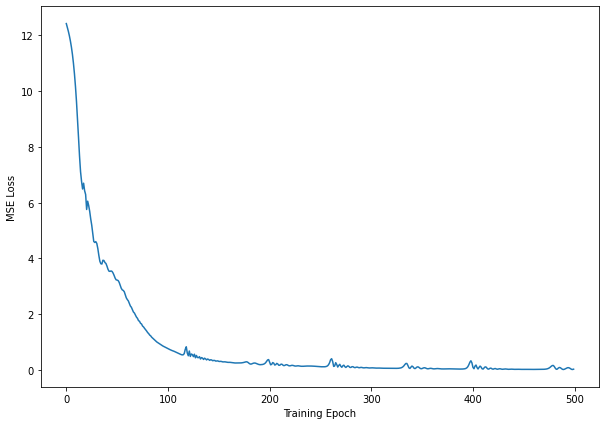

In [9]:
# training loop
loss_all = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # reset gradients 
    x.to(device) # mainly necessary for GPU
    y, h = model.forward(x)
    loss = criterion(y, t)
    loss.backward() # this line does all backprop + grad calculation!
    optimizer.step() # updates weights
    
    if epoch%20 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
    
    # store loss
    loss_all.append(loss.detach().numpy())

# plot loss
plt.figure(figsize=(10,7))
plt.plot(loss_all)
plt.xlabel("Training Epoch")
plt.ylabel("MSE Loss")
plt.show()

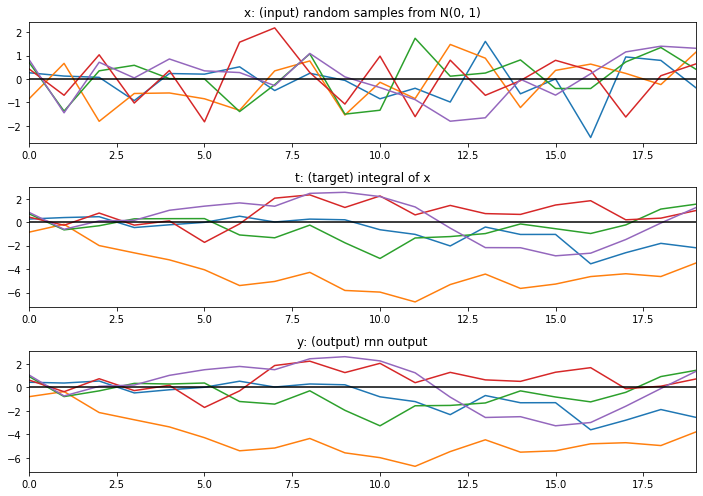

In [10]:
# plot performance on the training set
y, h = model.forward(x)
plot_integration(x, t, y)

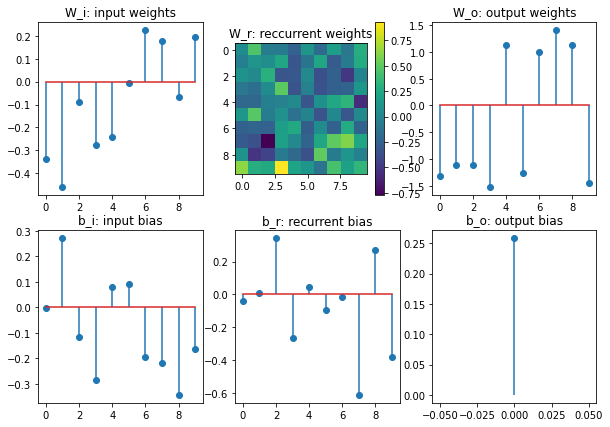

In [11]:
# plot trained weights
plot_weights(model)

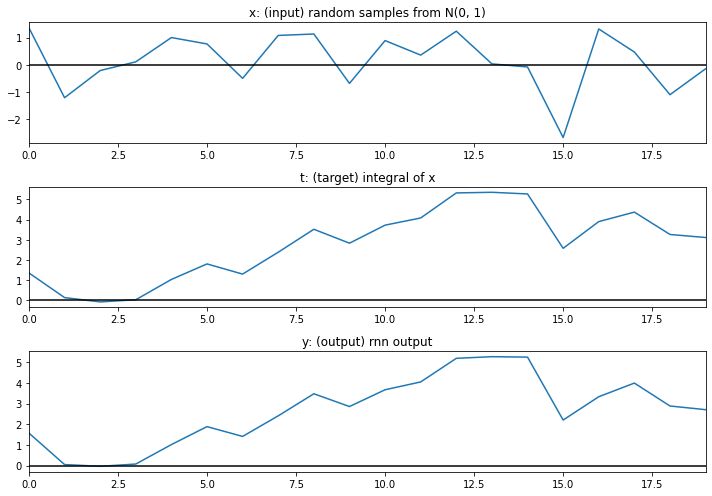

Test MSE loss: 0.053201


In [12]:
# test with a new random input
x_test, t_test = generate_input_target(input_size, seq_len=20, n_seq=1)
x_test = torch.Tensor(x_test)
t_test = torch.Tensor(t_test)

y_test, h = model.forward(x_test)
plot_integration(x_test, t_test, y_test)

loss_test = float(criterion(y_test, t_test))
print("Test MSE loss: %f" % loss_test)

## Digging deeper

There are many things worth tinkering with using this toy model.
- Generalizability: You might want to generate an entire test set to evaluate training vs test performance. Maybe more interesting: can the RNN generalize to a longer `seq_len` than we used for training?
- Number of hidden units: Play around with different values for `hidden_size`.. can the network perform integration with 1 unit?
- Sequence length: The longer the input sequence, the further we have to backpropagate errors. How does `seq_len` impact training/performance? Do errors accumulate over time?
- Number of training examples: How does `n_seq` impact training? Generalizability?
- Training hyperparams: Changing `n_epochs` will change the number of times we run backprop on the dataset, and `lr` controls the learning rate.
- Hidden unit activation: You can access the hidden state across all timesteps using `model.h_all`.
